In [2]:
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, balanced_accuracy_score, roc_auc_score

sys.path.append(str(Path.cwd().parent))
from utils import DATA_DIR

In [8]:
import platform
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False

mpl.rcParams['axes.unicode_minus'] = False
# 폰트 개인 경로에 맞춰서 변경
# FONT_DIR = Path("/path/to/fonts")
# font_path = FONT_DIR / 'FREESENTATION-6SEMIBOLD.ttf'
# prop = fm.FontProperties(fname=font_path)

In [3]:
df = pd.read_csv(DATA_DIR /'interim' / 'milk.csv')
df.head()

,농장아이디,개체번호,검정일자,누적착유일(연계),유지방율,유단백,무지고형분,체세포수,MUN,305일유량,...,농후사료급여량(연계),공태일수,유량,질병군,우유등급,비유초기평균MUN.1,비유최고도달일수_log,건유전마지막유량_log,공태일수_log,PF비
0,21133,2.007121e+13,2021-03-18,445,6.60,3.28,8.87,274,11.6,15158.0,...,0.0,619,76169939,0,2등급이하,NaN,4.143135,4.330733,6.429719,0.496970
1,21133,2.007121e+13,2021-04-28,486,3.64,3.33,8.91,166,11.0,15158.0,...,0.0,619,76170244,0,1등급,NaN,4.143135,4.330733,6.429719,0.914835
2,21133,2.007121e+13,2021-05-20,508,2.61,3.35,9.14,156,10.8,15158.0,...,0.0,619,76170487,0,1등급,NaN,4.143135,4.330733,6.429719,1.283525
3,21133,2.007121e+13,2021-06-25,544,3.75,3.49,8.99,307,14.1,15158.0,...,0.0,619,76170734,0,2등급이하,NaN,4.143135,4.330733,6.429719,0.930667
4,21133,2.007121e+13,2021-07-07,556,3.68,3.74,9.31,34,16.2,15158.0,...,0.0,619,76170903,0,1등급,NaN,4.143135,4.330733,6.429719,1.016304


In [4]:
df.shape

(58441, 40)

In [5]:
df.info() # nan값은 pipeline으로 처리할 예정.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58441 entries, 0 to 58440
Data columns (total 40 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   농장아이디         58441 non-null  int64  
 1   개체번호          58441 non-null  float64
 2   검정일자          58441 non-null  object 
 3   누적착유일(연계)     58441 non-null  int64  
 4   유지방율          42084 non-null  float64
 5   유단백           42084 non-null  float64
 6   무지고형분         42084 non-null  float64
 7   체세포수          58441 non-null  int64  
 8   MUN           42084 non-null  float64
 9   305일유량        43678 non-null  float64
 10  305일유지량       43678 non-null  float64
 11  305일유단백       43678 non-null  float64
 12  305일무지고형분     43678 non-null  float64
 13  성년유량          43678 non-null  float64
 14  성년유지량         43678 non-null  float64
 15  성년유단백량        43678 non-null  float64
 16  성년무지고형분량      43678 non-null  float64
 17  전산차비유지속성      58440 non-null  float64
 18  현재산차비유지속성     58440 non-nu

In [ ]:
df.describe()

,농장아이디,개체번호,누적착유일(연계),유지방율,유단백,무지고형분,체세포수,MUN,305일유량,305일유지량,...,농후사료비(연계),농후사료급여량(연계),공태일수,유량,질병군,비유초기평균MUN.1,비유최고도달일수_log,건유전마지막유량_log,공태일수_log,PF비
count,58441.000000,5.844100e+04,58441.000000,42084.000000,42084.000000,42084.000000,58441.000000,42084.000000,43678.000000,43678.000000,...,58441.000000,58441.000000,58441.000000,5.844100e+04,58441.000000,0.0,58440.000000,33724.000000,58441.000000,41919.000000
mean,20934.352663,2.016493e+13,202.230643,4.170827,3.313077,8.838642,126.464845,14.392603,10720.070104,431.150671,...,0.189097,0.261529,124.274516,4.707034e+07,0.001044,NaN,4.355995,3.808339,3.464868,0.831584
std,585.808734,1.935616e+10,150.494690,0.960408,0.413767,0.709344,381.293975,3.789614,2031.349473,106.409647,...,0.391589,0.439471,126.059024,3.055409e+07,0.032291,NaN,0.819051,1.158737,2.370168,0.209850
min,20249.000000,2.007121e+13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,755.000000,30.000000,...,0.000000,0.000000,0.000000,1.000000e+00,0.000000,NaN,0.000000,0.000000,0.000000,0.217631
25%,20269.000000,2.015121e+13,76.000000,3.630000,3.080000,8.580000,0.000000,11.900000,9384.000000,360.000000,...,0.000000,0.000000,0.000000,1.589173e+07,0.000000,NaN,3.912023,3.931826,0.000000,0.721709
50%,21137.000000,2.017042e+13,188.000000,4.140000,3.300000,8.870000,38.000000,13.900000,10650.000000,424.000000,...,0.000000,0.000000,99.000000,6.066701e+07,0.000000,NaN,4.369448,4.077537,4.605170,0.805419
75%,21278.000000,2.018041e+13,303.000000,4.680000,3.540000,9.150000,111.000000,16.500000,12035.000000,494.000000,...,0.000000,1.000000,193.000000,7.617652e+07,0.000000,NaN,4.875197,4.204693,5.267858,0.895151
max,21876.000000,2.021010e+13,1101.000000,9.990000,8.900000,13.930000,20484.000000,57.200000,21284.000000,1235.000000,...,1.000000,1.000000,974.000000,9.583738e+07,1.000000,NaN,6.643790,6.513230,6.882437,4.837838


In [ ]:
cols = ['누적착유일연계', '전산차비유지속성', '현재산차비유지속성', '비유최고도달일수_log',
'건유전마지막유량_log', '전산차건유전유량', '출생일자', '산차', '농후사료비(연계)',
'농후사료급여량(연계)', '공태일수_log']

<Axes: xlabel='우유등급', ylabel='비유최고도달일수_log'>

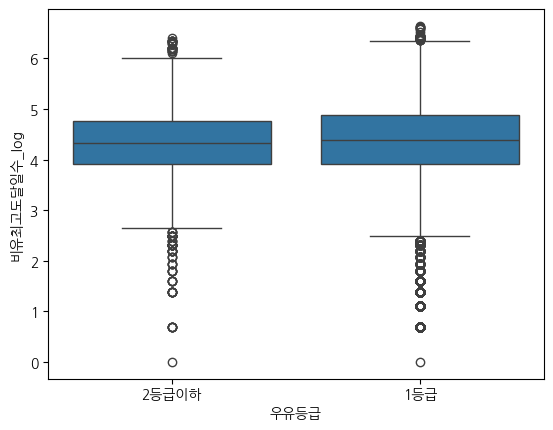

In [ ]:
sns.boxplot(df, x='우유등급', y='비유최고도달일수_log') # 우유등급별로 다른 결측치 처리를 해야겠음.

# 결측치 처리

각 우유등급 별로 다른 결측치 채우기를 해줘야 할 것.

In [ ]:
df['review_score'] = df.groupby('우유등급')['review_score'].transform(lambda x: x.fillna(x.median())) # 나중에 다같이 자세히 공부하기!
df['delay_rate'] = df.groupby('우유등급')['delay_rate'].transform(lambda x: x.fillna(x.median()))

df

,review_score,delay_rate,monthly_avg_orders,total_sale,order_cnt,product_cnt,cluster
0,3.00,66.67,0.75,218.70,3,3,group_0
1,4.65,5.00,2.50,11703.07,41,30,group_0
2,5.00,0.00,1.00,158.00,1,1,group_0
3,5.00,0.00,1.00,79.99,1,1,group_0
4,1.00,100.00,1.00,167.99,1,1,group_1
...,...,...,...,...,...,...,...
3082,5.00,0.00,2.00,158.00,2,1,group_0
3083,4.10,10.00,0.67,889.00,10,4,group_0
3084,5.00,0.00,1.40,550.04,7,6,group_0
3085,4.70,0.00,0.00,297.00,11,1,group_0


In [ ]:
df.isna().sum()

,0
review_score,0
delay_rate,0
monthly_avg_orders,0
total_sale,0
order_cnt,0
product_cnt,0
cluster,0


# 변수들 간의 상관관계 확인해서 review_score, monthly_avg_orders와 상관계수 높은 것들은 제거하거나 처리

<Axes: >

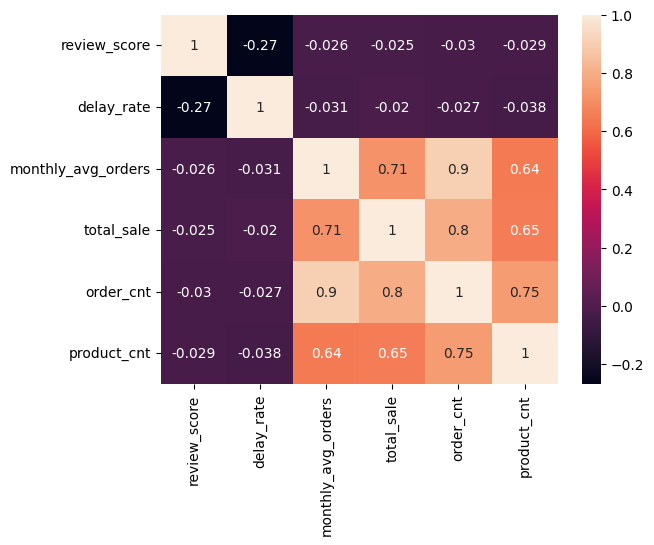

In [ ]:
sns.heatmap(df[['review_score', 'delay_rate', 'monthly_avg_orders', 'total_sale', 'order_cnt', 'product_cnt']].corr(), annot=True)

매출액을 주문건수로 나누면 평균 단가:

df['avg_order_value'] = df['total_sale'] / df['order_cnt']

이걸 feature로 쓰면 주문 수(order_cnt)의 영향이 제거되고, total_sale이 DBSCAN 라벨과 직접 연관되는 정도가 줄어듦

<Axes: >

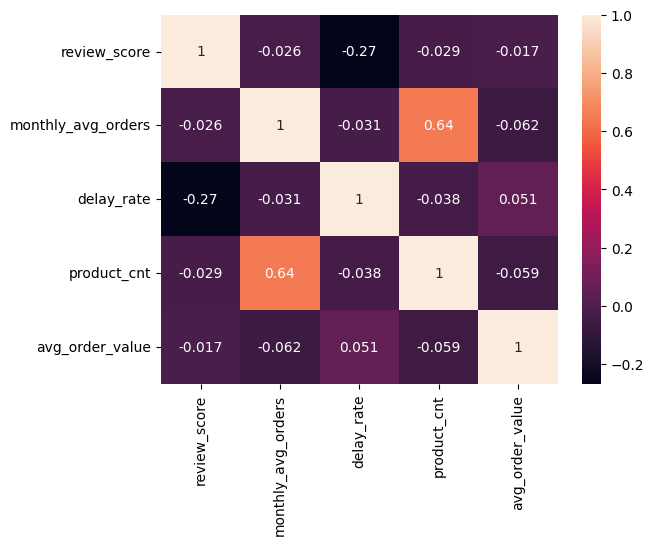

In [ ]:
sns.heatmap(df[['review_score', 'monthly_avg_orders', 'delay_rate', 'product_cnt', 'avg_order_value']].corr(), annot=True)

# df train/test로 분리해야 함

In [ ]:
df['우유등급'].value_counts()

,count
cluster,
group_0,2970
group_1,71
else,46


In [ ]:
X = df[['product_cnt', 'avg_order_value', 'delay_rate']]
y = df['우유등급']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline 만들고 GridSearchCV 적용해서 best model 찾기!

In [ ]:
# 파이프라인 정의
pipeline = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# 탐색할 파라미터 설정
param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [5, 10, 15],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

# GridSearchCV 설정
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)

# 학습
grid_search.fit(X_train, y_train)

# 결과 확인
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'rf__max_depth': 15, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
Best Score: 0.941305167831044


In [ ]:
# 최적 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [ ]:
# 멀티클래스
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("F1_macro:", f1_macro)
print("F1_weighted:", f1_weighted)

F1_macro: 0.3926127600105666
F1_weighted: 0.9246892547815023


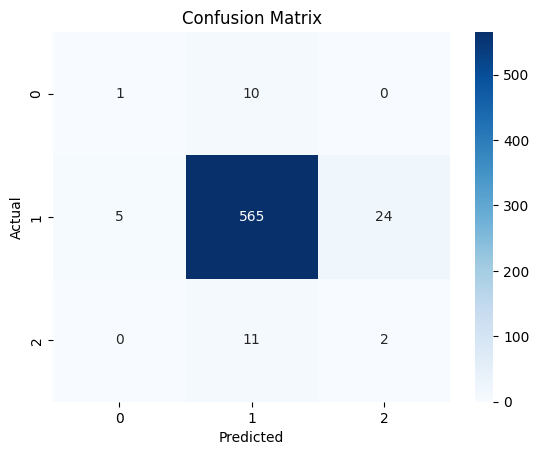

In [ ]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

SMOTE도 해보기

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [ ]:
# 파이프라인 정의
pipeline = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

# 탐색할 파라미터 설정
param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [5, 10, 15],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

# GridSearchCV 설정
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)

# 학습
grid_search.fit(X_train_res, y_train_res)

# 결과 확인
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'rf__max_depth': 15, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 10, 'rf__n_estimators': 300}
Best Score: 0.9008787904469828


In [ ]:
# 최적 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [ ]:
# 멀티클래스
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("F1_macro:", f1_macro)
print("F1_weighted:", f1_weighted)

F1_macro: 0.3542886492039034
F1_weighted: 0.8082092938601084


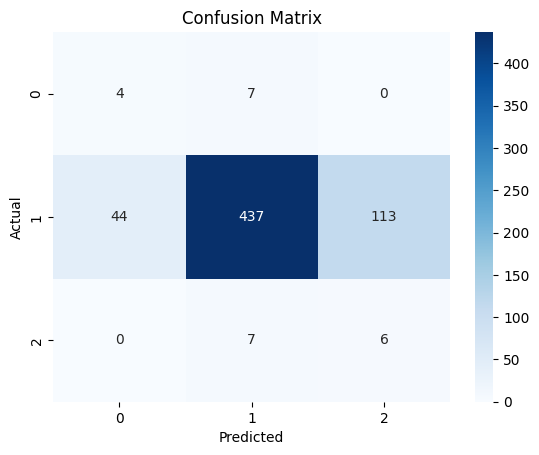

In [ ]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 튜터님 조언: 단순 복제 oversampling 사용

## RF

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_res2, y_train_res2 = ros.fit_resample(X_train, y_train)

In [ ]:
# 파이프라인 정의
pipeline = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

# 탐색할 파라미터 설정
param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [5, 10, 15],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
    'f1_weighted': 'f1_weighted'
}


# GridSearchCV 설정
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='f1_macro',
    n_jobs=-1,
    verbose=2
)

# 학습
grid_search.fit(X_train_res2, y_train_res2)

# 결과 확인
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'rf__max_depth': 15, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 300}
Best Score: 0.980984701215158


In [ ]:
# 최적 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("accuray:", accuracy)
print("F1_macro:", f1_macro)
print("F1_weighted:", f1_weighted)

accuray: 0.8980582524271845
F1_macro: 0.4361557044274155
F1_weighted: 0.9158021505273758


In [ ]:
print("per-class F1:", classification_report(y_test, y_pred, digits=3))

bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"\n⚖️ Balanced Accuracy: {bal_acc:.3f}")

# 다중 클래스 → One-vs-One 방식으로 평균
y_test_bin = label_binarize(y_test, classes=np.unique(y))
roc_auc_ovo = roc_auc_score(y_test_bin, y_prob, multi_class='ovo', average='macro')
print(f"💡 ROC-AUC (OvO, macro): {roc_auc_ovo:.3f}")

per-class F1:               precision    recall  f1-score   support

        else      0.300     0.273     0.286        11
     group_0      0.967     0.926     0.946       594
     group_1      0.051     0.154     0.077        13

    accuracy                          0.898       618
   macro avg      0.439     0.451     0.436       618
weighted avg      0.935     0.898     0.916       618


⚖️ Balanced Accuracy: 0.451
💡 ROC-AUC (OvO, macro): 0.778


## LightGBM

In [ ]:
import lightgbm as lgb
from imblearn.pipeline import Pipeline

RandomOverSampler 사용

In [ ]:
# train/test 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Pipeline 구성 (RandomOverSampler + LightGBM)
pipeline = Pipeline([
    ('oversample', RandomOverSampler(random_state=42)),
    ('clf', lgb.LGBMClassifier(
        objective='multiclass',
        num_class=3,
        random_state=42
    ))
])

param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [5, 10, None],
    'clf__learning_rate': [0.05, 0.1],
    'clf__min_child_samples': [1, 5, 10],
    'clf__min_gain_to_split': [0, 0.01, 0.05]
}


# scoring 지표
scoring = {
    'f1_macro': 'f1_macro',
    'balanced_accuracy': 'balanced_accuracy'
}

# GridSearchCV 설정
grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring=scoring,
    refit='f1_macro',  # 최종 모델은 f1_macro 기준 선택
    cv=5,
    n_jobs=-1,
    verbose=2
)

# 학습
grid.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[LightGBM] [Warning] min_gain_to_split is set=0.05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05
[LightGBM] [Warning] min_gain_to_split is set=0.05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 577
[LightGBM] [Info] Number of data points in the train set: 7125, number of used features: 3
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('oversample',
                                        RandomOverSampler(random_state=42)),
                                       ('clf',
                                        LGBMClassifier(num_class=3,
                                                       objective='multiclass',
                                                       random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__learning_rate': [0.05, 0.1],
                         'clf__max_depth': [5, 10, None],
                         'clf__min_child_samples': [1, 5, 10],
                         'clf__min_gain_to_split': [0, 0.01, 0.05],
                         'clf__n_estimators': [100, 200, 300]},
             refit='f1_macro',
             scoring={'balanced_accuracy': 'balanced_accuracy',
                      'f1_macro': 'f1_macro'},
             verbose=2)

In [ ]:
# 결과 요약
results = pd.DataFrame(grid.cv_results_)[
    ['param_clf__n_estimators', 'param_clf__max_depth', 'param_clf__learning_rate',
     'mean_test_f1_macro', 'mean_test_balanced_accuracy']
]
print("\nGridSearchCV 결과 요약:")
print(results)

print("\nBest params (기준: f1_macro):", grid.best_params_)
print("Best f1_macro score:", grid.best_score_)


GridSearchCV 결과 요약:
     param_clf__n_estimators param_clf__max_depth  param_clf__learning_rate  \
0                        100                    5                      0.05   
1                        200                    5                      0.05   
2                        300                    5                      0.05   
3                        100                    5                      0.05   
4                        200                    5                      0.05   
..                       ...                  ...                       ...   
157                      200                 None                      0.10   
158                      300                 None                      0.10   
159                      100                 None                      0.10   
160                      200                 None                      0.10   
161                      300                 None                      0.10   

     mean_test_f1_macro  mean_

In [ ]:
# 테스트셋 성능 평가
y_pred = grid.predict(X_test)
y_prob = grid.predict_proba(X_test)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred, digits=3))

# Balanced Accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"\nBalanced Accuracy (Test Set): {bal_acc:.3f}")

# ROC-AUC (OvO, macro)
y_test_bin = label_binarize(y_test, classes=np.unique(y))
roc_auc_ovo = roc_auc_score(y_test_bin, y_prob, multi_class='ovo', average='macro')
print(f"ROC-AUC (OvO, macro, Test Set): {roc_auc_ovo:.3f}")

[LightGBM] [Warning] min_gain_to_split is set=0.05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05
[LightGBM] [Warning] min_gain_to_split is set=0.05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05

Classification Report (Test Set):
              precision    recall  f1-score   support

        else      0.200     0.111     0.143         9
     group_0      0.965     0.936     0.951       595
     group_1      0.056     0.143     0.080        14

    accuracy                          0.906       618
   macro avg      0.407     0.397     0.391       618
weighted avg      0.934     0.906     0.919       618


Balanced Accuracy (Test Set): 0.397
ROC-AUC (OvO, macro, Test Set): 0.729


In [ ]:
# Confusion Matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred),
                  index=[f"True_{c}" for c in np.unique(y)],
                  columns=[f"Pred_{c}" for c in np.unique(y)])
print("\nConfusion Matrix (Test Set):")
print(cm)


Confusion Matrix (Test Set):
              Pred_else  Pred_group_0  Pred_group_1
True_else             1             8             0
True_group_0          4           557            34
True_group_1          0            12             2


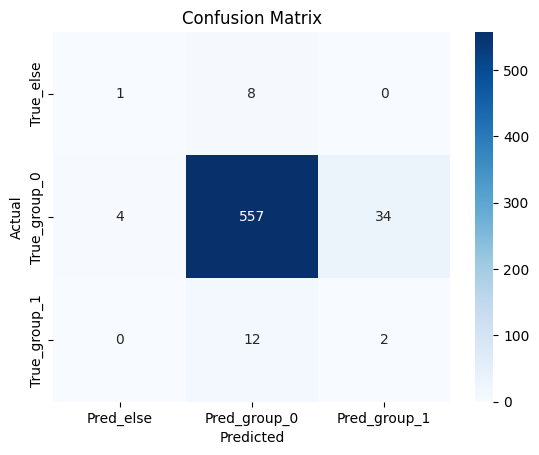

In [ ]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

scale_pos_weight 사용

In [ ]:
from collections import Counter

counter = Counter(y_train)
print(counter)

# 기준 클래스 (다수 클래스)
major_class = 'group_0'
major_count = counter[major_class]

# scale_pos_weight 계산
scale_pos_weight = {cls: round(major_count / count, 2) for cls, count in counter.items()}
print(scale_pos_weight)

Counter({'group_0': 2375, 'group_1': 57, 'else': 37})
{'group_0': 1.0, 'else': 64.19, 'group_1': 41.67}


In [ ]:
lgb_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(counter),
    class_weight='scale_pos_weight',
    random_state=42
)

# 하이퍼파라미터 그리드
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'learning_rate': [0.05, 0.1],
    'min_child_samples': [1, 5, 10],
    'min_gain_to_split': [0, 0.01, 0.05]
}

# scoring 지표
scoring = {
    'f1_macro': 'f1_macro',
    'balanced_accuracy': 'balanced_accuracy'
}

# GridSearchCV
grid = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=2,
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 2469, number of used features: 3
[LightGBM] [Info] Start training from score -1.098630
[LightGBM] [Info] Start training from score -1.098643
[LightGBM] [Info] Start training from score -1.098563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

GridSearchCV(cv=5,
             estimator=LGBMClassifier(class_weight={'else': 64.19,
                                                    'group_0': 1.0,
                                                    'group_1': 41.67},
                                      num_class=3, objective='multiclass',
                                      random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1],
                         'max_depth': [5, 10, None],
                         'min_child_samples': [1, 5, 10],
                         'min_gain_to_split': [0, 0.01, 0.05],
                         'n_estimators': [100, 200, 300]},
             refit='f1_macro',
             scoring={'balanced_accuracy': 'balanced_accuracy',
                      'f1_macro': 'f1_macro'},
             verbose=2)

In [ ]:
# 결과 요약
results = pd.DataFrame(grid.cv_results_)[
    ['param_n_estimators', 'param_max_depth', 'param_learning_rate',
     'mean_test_f1_macro', 'mean_test_balanced_accuracy']
]
print("\nGridSearchCV 결과 요약:")
print(results)

print("\nBest params (기준: f1_macro):", grid.best_params_)
print("Best f1_macro score:", grid.best_score_)


GridSearchCV 결과 요약:
     param_n_estimators param_max_depth  param_learning_rate  \
0                   100               5                 0.05   
1                   200               5                 0.05   
2                   300               5                 0.05   
3                   100               5                 0.05   
4                   200               5                 0.05   
..                  ...             ...                  ...   
157                 200            None                 0.10   
158                 300            None                 0.10   
159                 100            None                 0.10   
160                 200            None                 0.10   
161                 300            None                 0.10   

     mean_test_f1_macro  mean_test_balanced_accuracy  
0              0.436450                     0.572258  
1              0.451765                     0.489443  
2              0.444162                     0

In [ ]:
# 테스트셋 성능 평가
y_pred = grid.predict(X_test)
y_prob = grid.predict_proba(X_test)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred, digits=3))

# Balanced Accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"\nBalanced Accuracy (Test Set): {bal_acc:.3f}")

# ROC-AUC (OvO, macro)
y_test_bin = label_binarize(y_test, classes=np.unique(y))
roc_auc_ovo = roc_auc_score(y_test_bin, y_prob, multi_class='ovo', average='macro')
print(f"ROC-AUC (OvO, macro, Test Set): {roc_auc_ovo:.3f}")

[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0

Classification Report (Test Set):
              precision    recall  f1-score   support

        else      0.100     0.111     0.105         9
     group_0      0.971     0.886     0.926       595
     group_1      0.092     0.429     0.152        14

    accuracy                          0.864       618
   macro avg      0.388     0.475     0.394       618
weighted avg      0.938     0.864     0.897       618


Balanced Accuracy (Test Set): 0.475
ROC-AUC (OvO, macro, Test Set): 0.786


In [ ]:
# Confusion Matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred),
                  index=[f"True_{c}" for c in np.unique(y)],
                  columns=[f"Pred_{c}" for c in np.unique(y)])
print("\nConfusion Matrix (Test Set):")
print(cm)


Confusion Matrix (Test Set):
              Pred_else  Pred_group_0  Pred_group_1
True_else             1             8             0
True_group_0          9           527            59
True_group_1          0             8             6


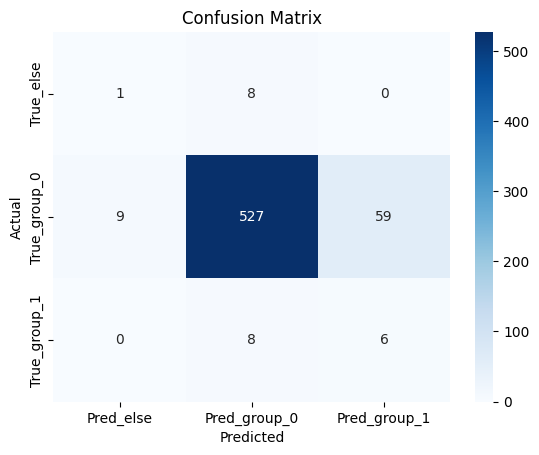

In [ ]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## class_weight='balanced', 하이퍼파라미터 튜닝 변경

In [ ]:
# train/test 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

lgb_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=3,
    class_weight='balanced',
    random_state=42
)

# 하이퍼파라미터 그리드
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'learning_rate': [0.01, 0.05],
    'num_leaves': [31, 63],
    'min_child_samples': [1, 3, 5],
    'min_gain_to_split': [0, 0.01, 0.05]
}


# scoring 지표
scoring = {
    'f1_macro': 'f1_macro',
    'balanced_accuracy': 'balanced_accuracy'
}

# GridSearchCV
grid = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=2,
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 2469, number of used features: 3
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


GridSearchCV(cv=5,
             estimator=LGBMClassifier(class_weight='balanced', num_class=3,
                                      objective='multiclass', random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05],
                         'max_depth': [5, 10, 20],
                         'min_child_samples': [1, 3, 5],
                         'n_estimators': [100, 200, 300, 400],
                         'num_leaves': [31, 63]},
             refit='f1_macro',
             scoring={'balanced_accuracy': 'balanced_accuracy',
                      'f1_macro': 'f1_macro'},
             verbose=2)

In [ ]:
# 결과 요약
results = pd.DataFrame(grid.cv_results_)[
    ['param_n_estimators', 'param_max_depth', 'param_learning_rate',
     'mean_test_f1_macro', 'mean_test_balanced_accuracy']
]
print("\nGridSearchCV 결과 요약:")
print(results)

print("\nBest params (기준: f1_macro):", grid.best_params_)
print("Best f1_macro score:", grid.best_score_)


GridSearchCV 결과 요약:
     param_n_estimators  param_max_depth  param_learning_rate  \
0                   100                5                 0.01   
1                   100                5                 0.01   
2                   200                5                 0.01   
3                   200                5                 0.01   
4                   300                5                 0.01   
..                  ...              ...                  ...   
139                 200               20                 0.05   
140                 300               20                 0.05   
141                 300               20                 0.05   
142                 400               20                 0.05   
143                 400               20                 0.05   

     mean_test_f1_macro  mean_test_balanced_accuracy  
0              0.415632                     0.694122  
1              0.415632                     0.694122  
2              0.423570          

In [ ]:
# 테스트셋 성능 평가
y_pred = grid.predict(X_test)
y_prob = grid.predict_proba(X_test)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred, digits=3))

# Balanced Accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"\nBalanced Accuracy (Test Set): {bal_acc:.3f}")

# ROC-AUC (OvO, macro)
y_test_bin = label_binarize(y_test, classes=np.unique(y))
roc_auc_ovo = roc_auc_score(y_test_bin, y_prob, multi_class='ovo', average='macro')
print(f"ROC-AUC (OvO, macro, Test Set): {roc_auc_ovo:.3f}")


Classification Report (Test Set):
              precision    recall  f1-score   support

        else      0.083     0.111     0.095         9
     group_0      0.965     0.829     0.892       595
     group_1      0.042     0.286     0.073        14

    accuracy                          0.806       618
   macro avg      0.363     0.408     0.353       618
weighted avg      0.931     0.806     0.861       618


Balanced Accuracy (Test Set): 0.408
ROC-AUC (OvO, macro, Test Set): 0.771


In [ ]:
# Confusion Matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred),
                  index=[f"True_{c}" for c in np.unique(y)],
                  columns=[f"Pred_{c}" for c in np.unique(y)])
print("\nConfusion Matrix (Test Set):")
print(cm)


Confusion Matrix (Test Set):
              Pred_else  Pred_group_0  Pred_group_1
True_else             1             8             0
True_group_0         11           493            91
True_group_1          0            10             4


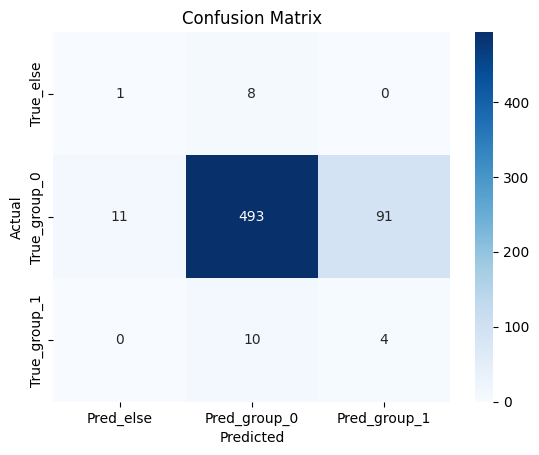

In [ ]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

randomoversampler 일부만, class_weight, 하이퍼파라미터 튜닝

In [ ]:
# train/test 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 일부만 RandomOverSampler 적용
# 소수 클래스 target 샘플 수 직접 지정
sampling_strategy = {
    'group_1': 1000,  # group_1 샘플 증가
    'else': 1000      # else 샘플 증가
}
ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)

# LightGBM 파이프라인
pipeline = Pipeline([
    ('oversample', ros),
    ('clf', lgb.LGBMClassifier(
        objective='multiclass',
        is_unbalance=True,
        class_weight='balanced',
        num_class=3,
        random_state=42
    ))
]) # 분류 모델의 클래스 threshold 조정하여 낮은 확률이더라도 맞출 수 있도록 하기.

# 하이퍼파라미터 그리드
param_grid = {
    'clf__n_estimators': [200, 400],
    'clf__max_depth': [10, 20],
    'clf__learning_rate': [0.01, 0.05],
    'clf__num_leaves': [31, 63, 127],
    'clf__min_child_samples': [1, 3, 5],
    'clf__min_gain_to_split': [0, 0.01, 0.05]
}

# 평가 지표
scoring = {
    'f1_macro': 'f1_macro',
    'balanced_accuracy': 'balanced_accuracy',
    'average_precision_macro': 'average_precision_macro'
}

# GridSearchCV
grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring=scoring,
    refit='average_precision_macro',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# 학습
grid.fit(X_train, y_train)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 585
[LightGBM] [Info] Number of data points in the train set: 4375, number of used features: 3
[LightGBM] [Info] Start training from score -1.475907
[LightGBM] [Info] Start training from score -0.610909
[LightGBM] [Info] Start training from score -1.475907


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('oversample',
                                        RandomOverSampler(random_state=42,
                                                          sampling_strategy={'else': 1000,
                                                                             'group_1': 1000})),
                                       ('clf',
                                        LGBMClassifier(is_unbalance=True,
                                                       num_class=3,
                                                       objective='multiclass',
                                                       random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__learning_rate': [0.01, 0.05],
                         'clf__max_depth': [10, 20],
                         'clf__min_child_samples': [1, 3, 5],
                         'clf__min_gain_to_split': [0, 0.01, 0.05],
                         'clf__n_estimators': [200, 400],
                         'clf__num_leaves': [31, 63, 127]},
             refit='f1_macro',
             scoring={'balanced_accuracy': 'balanced_accuracy',
                      'f1_macro': 'f1_macro'},
             verbose=2)

In [ ]:
# 결과 요약
results = pd.DataFrame(grid.cv_results_)[
    ['param_clf__n_estimators', 'param_clf__max_depth', 'param_clf__learning_rate',
     'mean_test_f1_macro', 'mean_test_balanced_accuracy']
]
print("\nGridSearchCV 결과 요약:")
print(results)

print("\nBest params (기준: f1_macro):", grid.best_params_)
print("Best f1_macro score:", grid.best_score_)


GridSearchCV 결과 요약:
     param_clf__n_estimators  param_clf__max_depth  param_clf__learning_rate  \
0                        200                    10                      0.01   
1                        200                    10                      0.01   
2                        200                    10                      0.01   
3                        400                    10                      0.01   
4                        400                    10                      0.01   
..                       ...                   ...                       ...   
211                      200                    20                      0.05   
212                      200                    20                      0.05   
213                      400                    20                      0.05   
214                      400                    20                      0.05   
215                      400                    20                      0.05   

     mean_test_f1_

In [ ]:
y_pred = grid.predict(X_test)
y_prob = grid.predict_proba(X_test)

[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0


In [ ]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize

# 클래스 이름과 이진화
classes = grid.best_estimator_.named_steps['clf'].classes_
y_test_bin = label_binarize(y_test, classes=classes)

# 모델 확률 예측
y_prob = grid.predict_proba(X_test)  # shape = (n_samples, n_classes)

# 각 클래스별 최적 threshold 찾기
best_thresholds = {}
for i, cls in enumerate(classes):
    best_f1 = 0
    best_t = 0
    thresholds_to_try = np.linspace(0.1, 0.9, 81)  # 0.1~0.9까지 0.01 간격
    for t in thresholds_to_try:
        y_pred_cls = (y_prob[:, i] >= t).astype(int)
        f1 = f1_score(y_test_bin[:, i], y_pred_cls)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    best_thresholds[cls] = best_t
    print(f"Class {cls}: Best Threshold = {best_t:.2f}, Best F1 = {best_f1:.4f}")

# 최적 threshold 적용 후 멀티클래스 예측
y_pred_thresholded = []
for p in y_prob:
    # threshold 미만 확률은 0으로
    adjusted_p = np.array([prob if prob >= best_thresholds[cls] else 0
                           for cls, prob in zip(classes, p)])
    # 최대값 선택
    y_pred_thresholded.append(classes[np.argmax(adjusted_p)])
y_pred = np.array(y_pred_thresholded)

# 평가
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix

print("\nClassification Report (Threshold Optimized):")
print(classification_report(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
roc_auc_ovo = roc_auc_score(y_test_bin, y_prob, multi_class='ovo', average='macro') # <- 조정해도 값이 바뀔 수 없는 건가? 순서 기준으로 점수를 매겨서 임계값과
print(f"ROC-AUC (OvO, macro, Test Set): {roc_auc_ovo:.3f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# PR-AUC 계산
pr_auc_dict = {}
for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    pr_auc = auc(recall, precision)
    pr_auc_dict[cls] = pr_auc
    print(f"Class {cls} - PR-AUC: {pr_auc:.4f}")

pr_auc_macro = np.mean(list(pr_auc_dict.values()))
print(f"Macro-average PR-AUC: {pr_auc_macro:.4f}")

y_pred = np.array(y_pred)

[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
Class else: Best Threshold = 0.89, Best F1 = 0.2000
Class group_0: Best Threshold = 0.10, Best F1 = 0.9785
Class group_1: Best Threshold = 0.56, Best F1 = 0.1667

Classification Report (Threshold Optimized):
              precision    recall  f1-score   support

        else       0.50      0.11      0.18         9
     group_0       0.97      0.97      0.97       595
     group_1       0.14      0.21      0.17        14

    accuracy                           0.94       618
   macro avg       0.53      0.43      0.44       618
weighted avg       0.94      0.94      0.94       618

Balanced Accuracy: 0.43059446000622464
ROC-AUC (OvO, macro, Test Set): 0.749
Confusion Matrix:
[[  1   8   0]
 [  1 575  19]
 [  0  11   3]]
Class else - PR-AUC: 0.1403
Class group_0 - PR-AUC: 0.9864
Class group_1 - PR-AUC: 0.0725
Macro-average PR-AUC: 0.3997


In [ ]:
# Confusion Matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred),
                  index=[f"True_{c}" for c in np.unique(y)],
                  columns=[f"Pred_{c}" for c in np.unique(y)])
print("\nConfusion Matrix (Test Set):")
print(cm)


Confusion Matrix (Test Set):
              Pred_else  Pred_group_0  Pred_group_1
True_else             1             8             0
True_group_0          1           575            19
True_group_1          0            11             3


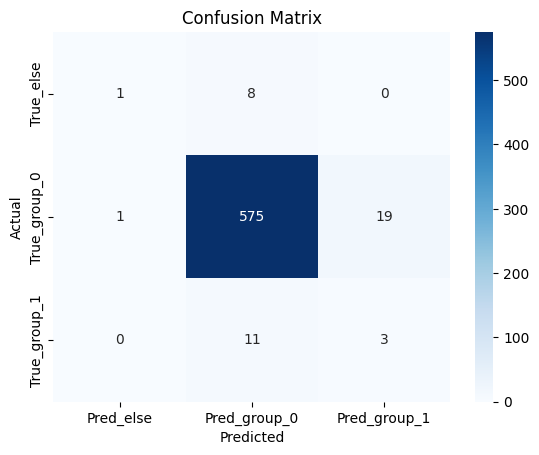

In [ ]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# SMOTE + LightGBM + class_weight + GridSearchCV

In [ ]:
from sklearn.metrics import make_scorer, average_precision_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# SMOTE 설정 (소수 클래스 적절히 늘리기)
smote = SMOTE(
    sampling_strategy={'group_1': 400, 'else': 400},
    random_state=42
)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# LightGBM classifier
lgbm_clf = lgb.LGBMClassifier(
    objective='multiclass',
    class_weight='balanced',  # 소수 클래스 가중치 자동 적용
    n_jobs=-1,
    random_state=42
)

# GridSearchCV 파라미터
param_grid = {
    'n_estimators': [200, 400],
    'max_depth': [10, 20],
    'learning_rate': [0.01, 0.05],
    'num_leaves': [31, 63, 127],
    'min_child_samples': [1, 3, 5],
    'min_gain_to_split': [0, 0.01, 0.05]
}

scoring = {
    'f1_macro': 'f1_macro',
    'balanced_accuracy': 'balanced_accuracy',
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=lgbm_clf,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1_macro',
    cv=cv,
    n_jobs=-1
)

# 학습
grid.fit(X_train_res, y_train_res)

# 결과 확인
print("Best params:", grid.best_params_)
print("Best f1_macro:", grid.best_score_)

[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 3175, number of used features: 3
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [ ]:
# 테스트 세트 예측
y_pred = grid.predict(X_test)
y_prob = grid.predict_proba(X_test)

# 테스트셋 성능 평가
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred, digits=3))

# Balanced Accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"\nBalanced Accuracy (Test Set): {bal_acc:.3f}")

# ROC-AUC (OvO, macro)
y_test_bin = label_binarize(y_test, classes=np.unique(y))
roc_auc_ovo = roc_auc_score(y_test_bin, y_prob, multi_class='ovo', average='macro')
print(f"ROC-AUC (OvO, macro, Test Set): {roc_auc_ovo:.3f}")

# Confusion Matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred),
                  index=[f"True_{c}" for c in np.unique(y)],
                  columns=[f"Pred_{c}" for c in np.unique(y)])
print("\nConfusion Matrix (Test Set):")
print(cm)

[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01

Classification Report (Test Set):
              precision    recall  f1-score   support

        else      0.125     0.222     0.160         9
     group_0      0.974     0.825     0.894       595
     group_1      0.082     0.571     0.143        14

    accuracy                          0.811       618
   macro avg      0.394     0.540     0.399       618
weighted avg      0.942     0.811     0.866       618


Balanced Accuracy (Test Set): 0.540
ROC-AUC (OvO, macro, Test Set): 0.822

Confusion Matrix (Test Set):
              Pred_else  Pred_group_0  Pred_group_1
True_else             2             7             0
True_group_0         14           491            90
True_group_1          0             6             8


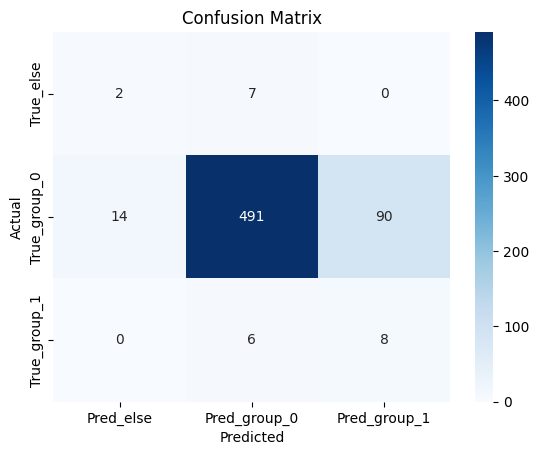

In [ ]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize

# 클래스 이름과 이진화
classes = grid.best_estimator_.classes_
y_test_bin = label_binarize(y_test, classes=classes)

# 모델 확률 예측
y_prob = grid.predict_proba(X_test)

# 각 클래스별 최적 threshold 찾기
best_thresholds = {}
for i, cls in enumerate(classes):
    best_f1 = 0
    best_t = 0
    thresholds_to_try = np.linspace(0.1, 0.9, 81)  # 0.1~0.9까지 0.01 간격
    for t in thresholds_to_try:
        y_pred_cls = (y_prob[:, i] >= t).astype(int)
        f1 = f1_score(y_test_bin[:, i], y_pred_cls)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    best_thresholds[cls] = best_t
    print(f"Class {cls}: Best Threshold = {best_t:.2f}, Best F1 = {best_f1:.4f}")

# 최적 threshold 적용 후 멀티클래스 예측
y_pred_thresholded = []
for p in y_prob:
    # threshold 미만 확률은 0으로
    adjusted_p = np.array([prob if prob >= best_thresholds[cls] else 0
                           for cls, prob in zip(classes, p)])
    # 최대값 선택
    y_pred_thresholded.append(classes[np.argmax(adjusted_p)])
y_pred = np.array(y_pred_thresholded)

# 평가
print("\nClassification Report (Threshold Optimized):")
print(classification_report(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
roc_auc_ovo = roc_auc_score(y_test_bin, y_prob, multi_class='ovo', average='macro')
print(f"ROC-AUC (OvO, macro, Test Set): {roc_auc_ovo:.3f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# PR-AUC 계산
pr_auc_dict = {}
for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    pr_auc = auc(recall, precision)
    pr_auc_dict[cls] = pr_auc
    print(f"Class {cls} - PR-AUC: {pr_auc:.4f}")

pr_auc_macro = np.mean(list(pr_auc_dict.values()))
print(f"Macro-average PR-AUC: {pr_auc_macro:.4f}")

[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
Class else: Best Threshold = 0.75, Best F1 = 0.2222
Class group_0: Best Threshold = 0.10, Best F1 = 0.9698
Class group_1: Best Threshold = 0.82, Best F1 = 0.2273

Classification Report (Threshold Optimized):
              precision    recall  f1-score   support

        else       0.22      0.22      0.22         9
     group_0       0.97      0.95      0.96       595
     group_1       0.17      0.36      0.23        14

    accuracy                           0.92       618
   macro avg       0.45      0.51      0.47       618
weighted avg       0.94      0.92      0.93       618

Balanced Accuracy: 0.5085278555866791
ROC-AUC (OvO, macro, Test Set): 0.822
Confusion Matrix:
[[  2   7   0]
 [  7 563  25]
 [  0   9   5]]
Class else - PR-AUC: 0.0976
Class group_0 - PR-AUC: 0.9862
Class group_1 - PR-AUC: 0.1650
Macro-average PR-AUC: 0.4163


In [ ]:
best_model = grid.best_estimator_

In [ ]:
best_model.feature_importances_

array([ 7097, 15994,  7553], dtype=int32)

[Text(0.5, 1.0, 'Feature Importance (gain)'),
 Text(0.5, 0, 'Feature Importance'),
 Text(0, 0.5, 'Features')]

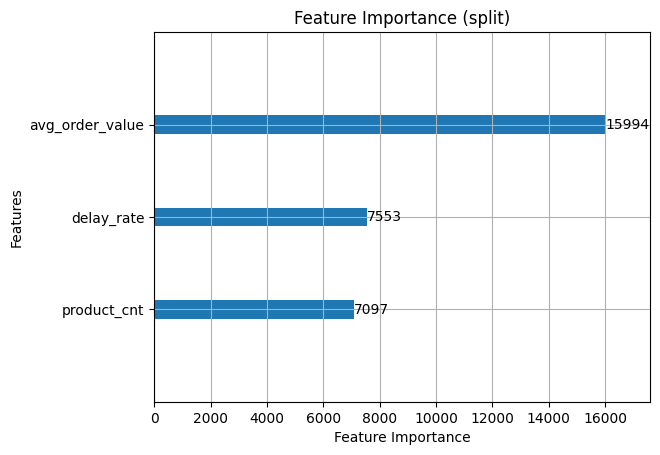

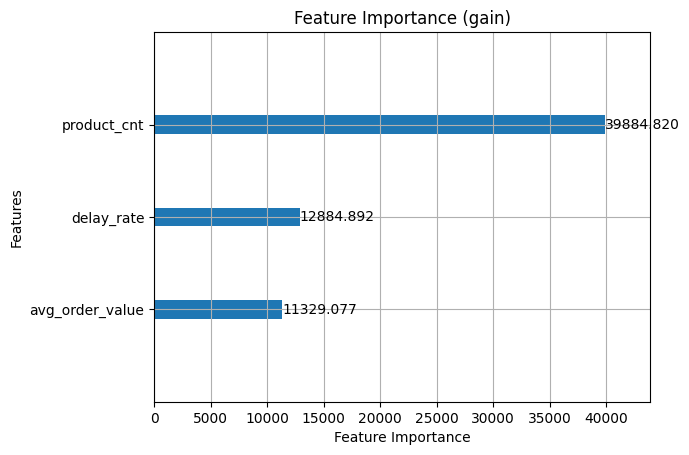

In [ ]:
# SPLIT
ax = lgb.plot_importance(best_model, max_num_features=3, importance_type='split')
ax.set(title=f'Feature Importance (split)',
	xlabel='Feature Importance',
	ylabel='Features')

# GAIN
ax = lgb.plot_importance(best_model, max_num_features=3, importance_type='gain')
ax.set(title=f'Feature Importance (gain)',
	xlabel='Feature Importance',
	ylabel='Features')

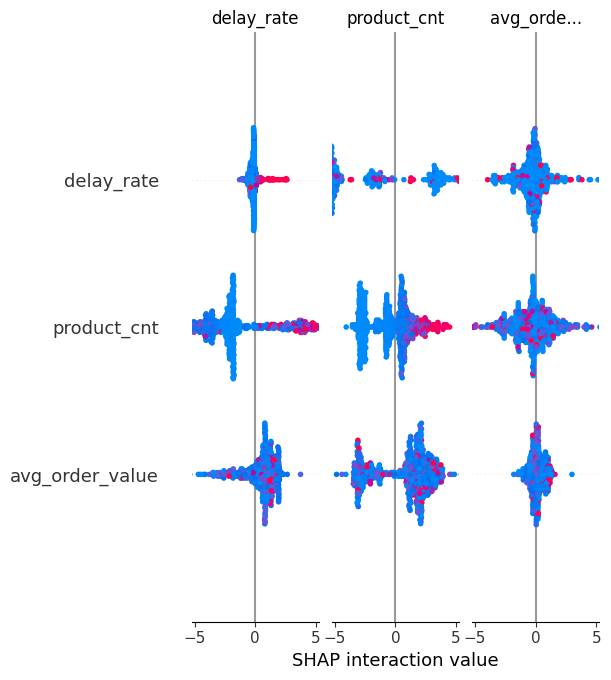

In [ ]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
fig = shap.summary_plot(shap_values, X_test)

In [ ]:
best_model.booster_.save_model('/content/drive/MyDrive/꾸러기_수비대/lgbm_booster.txt')

In [ ]:
import pickle

# 저장
with open('/content/drive/MyDrive/꾸러기_수비대/lgbm_pkl.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [ ]:
# 불러오기
with open('/content/drive/MyDrive/꾸러기_수비대/lgbm_pkl.pkl', 'rb') as f:
    loaded_clf = pickle.load(f)

In [ ]:
# 예측
y_pred = loaded_clf.predict(X_test)

[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
